6-3-2017

Drop Case5 as this is not clinically acceptable with AAA PTV D99% below 90% of prescription.

Drop Case14 as too hot on the D1cc.

Drop Cases 16 & 24 as too hot on DMAX.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import wilcoxon  # must import explicitly
import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def query_data(df, Col, structure, metric):   # helper function to get data, Col = AAA, AXB or diff 
    return df[Col][(df['structure'] == structure) & (df['metric'] == metric)]

In [3]:
# v2 ot the plot, show the case number as marker

def bland_altman_plot2(df, structure, metric, *args, **kwargs):
    data = df[(df['structure'] == structure) & (df['metric'] == metric)]
    
    Dm_data     = np.asarray(data['Dm'])
    AAA_data     = np.asarray(data['AAA'])
    cases = [case.replace('Case', '') for case in data['Case'].values]
    
    z_stat, p_val = wilcoxon(Dm_data, AAA_data)
    mean      = np.mean([Dm_data, AAA_data], axis=0)
    diff      = Dm_data - AAA_data                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    # plt.scatter(mean, diff, *args, **kwargs)
    plt.scatter(AAA_data, diff, *args, **kwargs)
    for i, txt in enumerate(cases):
        plt.annotate(txt, (AAA_data[i],diff[i]))
    
    plt.axhline(md,           color='red', linestyle='-')
    plt.axhline(md + 1.96*sd, color='blue', linestyle='--')
    plt.axhline(md - 1.96*sd, color='blue', linestyle='--')
    plt.xlabel('AAA Dose (Gy)')
    plt.ylabel('AXB - AAA Difference (Gy)')
   # plt.title( str(np.round(md, decimals = 3)) + ' Gy (' + str(np.round(md_percent, decimals = 3)) +  ' %) difference with p = ' + str(np.round(p_val, decimals = 3))  + ' for ' + structure + ' and metric ' + metric)
    plt.title( str(np.round(md, decimals = 3)) + ' Gy difference with p = ' + str(np.round(p_val, decimals = 3))  + '\n for ' + structure + ' and metric ' + metric)
    #plt.savefig('BA.png')

## Parse data

Load data and get in same format as original analysis, even though this is a bit long winded

In [4]:
data = pd.read_csv('metrics_all_7_2_2017.csv')  # import AAA data

In [5]:
data['Case'] = data['patID'].str.split('_').str.get(0)  # get the case ID e.g. case1
data['Algo'] = data['patID'].str.split('_').str.get(1)  # get the case ID e.g. case1

In [6]:
data = data.drop('patID', 1)  # drop the patID col

In [7]:
data = data.replace(to_replace='ribs', value='Ribs')    # Fix some lables
data = data.replace(to_replace='skin', value='Skin')

In [8]:
data['structure'].unique()

array(['BODY', 'GTV', 'Heart', 'Foramen', 'Oesophagus', 'Trachea',
       'Bronchial tree', 'L Brachial plex', 'Rt Brachial plex',
       'PTV CHEST', 'Lt_Lung', 'Rt_Lung', 'Both Lungs-ITV', 'Skin', 'ITV',
       'Ribs', 'Both Lungs', 'Liver'], dtype=object)

In [9]:
data.head()

,observed,metric,structure,Case,Algo
0,25.617688,D2%,BODY,Case1,AAA
1,14.391388,D5%,BODY,Case1,AAA
2,0.426561,D50%,BODY,Case1,AAA
3,0.046734,D95%,BODY,Case1,AAA
4,0.009347,D99%,BODY,Case1,AAA


In [10]:
data['Case'].unique()

array(['Case1', 'Case5', 'Case11', 'Case12', 'Case13', 'Case14', 'Case16',
       'Case17', 'Case22', 'Case24'], dtype=object)

In [11]:
data = data[data['Case'] != 'Case5']  # drop Case5
data = data[data['Case'] != 'Case14']  # drop Case5
data = data[data['Case'] != 'Case16']  # drop Case5
data = data[data['Case'] != 'Case24']  # drop Case5

In [12]:
print('number of cases is ' + str(len(data['Case'].unique())))
data['Case'].unique()

number of cases is 6


array(['Case1', 'Case11', 'Case12', 'Case13', 'Case17', 'Case22'], dtype=object)

In [13]:
AAA_df = data[data['Algo'] == 'AAA']
AAA_df.rename(columns={'observed': 'AAA'}, inplace=True)    # rename 
AAA_df = AAA_df.drop('Algo', 1)
#AAA_df.head()

/Users/robincole/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [14]:
Dm_df = data[data['Algo'] == 'AXB']
Dm_df.rename(columns={'observed': 'Dm'}, inplace=True)    # rename 
Dm_df = Dm_df.drop('Algo', 1)
#Dm_df.head()

/Users/robincole/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [15]:
AAA_Dm_data = pd.merge(AAA_df, Dm_df, how='inner', on=['metric', 'Case', 'structure'])  # Get merged set
AAA_Dm_data = AAA_Dm_data[['Case', 'structure', 'metric', 'AAA', 'Dm']]   # rearrange  
AAA_Dm_data.head()

,Case,structure,metric,AAA,Dm
0,Case1,BODY,D2%,25.617688,25.442482
1,Case1,BODY,D5%,14.391388,14.256952
2,Case1,BODY,D50%,0.426561,0.395687
3,Case1,BODY,D95%,0.046734,0.065460
4,Case1,BODY,D99%,0.009347,0.022070


In [16]:
AAA_Dm_data['Dm-AAA'] = AAA_Dm_data.Dm - AAA_Dm_data.AAA

In [17]:
AAA_Dm_data.head()

,Case,structure,metric,AAA,Dm,Dm-AAA
0,Case1,BODY,D2%,25.617688,25.442482,-0.175206
1,Case1,BODY,D5%,14.391388,14.256952,-0.134436
2,Case1,BODY,D50%,0.426561,0.395687,-0.030874
3,Case1,BODY,D95%,0.046734,0.065460,0.018727
4,Case1,BODY,D99%,0.009347,0.022070,0.012723


## Start analysis

In [18]:
AAA_Dm_data['Case'].unique()

array(['Case1', 'Case11', 'Case12', 'Case13', 'Case17', 'Case22'], dtype=object)

In [19]:
AAA_Dm_data['structure'].unique()

array(['BODY', 'GTV', 'Heart', 'Foramen', 'Oesophagus', 'Trachea',
       'Bronchial tree', 'L Brachial plex', 'Rt Brachial plex',
       'PTV CHEST', 'Lt_Lung', 'Rt_Lung', 'Both Lungs-ITV', 'Skin', 'ITV',
       'Ribs', 'Both Lungs', 'Liver'], dtype=object)

In [20]:
# AAA_Dm_data[AAA_Dm_data['structure'] == 'Heart']

In [21]:
AAA_Dm_data['metric'].unique()

array(['D2%', 'D5%', 'D50%', 'D95%', 'D99%', 'D1CC', 'D0.1CC', 'DMAX',
       'DSD', 'DRX', 'DHI'], dtype=object)

In [22]:
# Single metric

/Users/robincole/anaconda3/lib/python3.5/site-packages/scipy/stats/morestats.py:2384: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


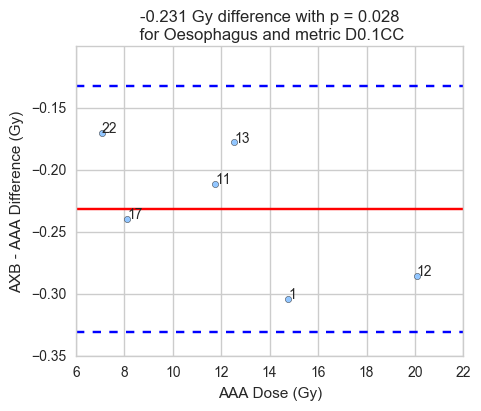

In [23]:
#structure = 'ITV'
#structure = 'Heart'
structure = structure = 'Oesophagus'
#structure = structure = 'Foramen'
metric = 'D0.1CC'
plt.figure(figsize=(5, 4)) 
bland_altman_plot2(AAA_Dm_data, structure, metric)
plt.show()

In [24]:
df = AAA_Dm_data[(AAA_Dm_data['structure'] == structure) & (AAA_Dm_data['metric'] == metric)]
df 

,Case,structure,metric,AAA,Dm,Dm-AAA
50,Case1,Oesophagus,D0.1CC,14.759799,14.456236,-0.303563
204,Case11,Oesophagus,D0.1CC,11.762174,11.551391,-0.210783
358,Case12,Oesophagus,D0.1CC,20.064096,19.778916,-0.285180
501,Case13,Oesophagus,D0.1CC,12.531614,12.354175,-0.177439
666,Case17,Oesophagus,D0.1CC,8.112150,7.872991,-0.239158
820,Case22,Oesophagus,D0.1CC,7.077255,6.907653,-0.169603


## Mean differences

In [25]:
mean_diff_table = AAA_Dm_data.groupby(['structure', 'metric'],as_index=False).mean().pivot(index='structure', columns='metric', values='Dm-AAA')

In [26]:
structures_of_interest = ['PTV CHEST','ITV','Foramen', 'Oesophagus', 'L Brachial plex', 'Rt Brachial plex', 'Heart', 'Trachea','Bronchial tree', 'Ribs', 'Liver', 'Skin']  # 'Oesophagus', 'Heart', 'GTV', 'Liver', 'Trachea', 'Bronchial tree',
metrics_of_interest  =  ['DMAX', 'D0.1CC', 'D1CC', 'D5%', 'D50%', 'D95%', 'D99%', 'DHI']

In [27]:
i = len(structures_of_interest)
j = len(metrics_of_interest)
wilcox_data = np.zeros((i,j))  # init an empty array

In [28]:
sub_diff_table = mean_diff_table[metrics_of_interest].loc[structures_of_interest]

In [29]:
sub_diff_table

metric,DMAX,D0.1CC,D1CC,D5%,D50%,D95%,D99%,DHI
structure,,,,,,,,
PTV CHEST,0.962500,0.535300,0.497390,0.417288,0.380172,-0.331874,-0.678363,0.014311
ITV,0.962500,0.430529,0.445857,0.472842,0.049686,-0.118558,-0.243105,0.010255
Foramen,-0.440000,-0.391448,-0.335099,-0.317831,-0.086760,0.015619,0.014504,0.444132
Oesophagus,-0.302500,-0.230954,-0.167826,-0.152392,-0.016565,0.017859,0.005248,0.113066
L Brachial plex,-0.018333,-10.457870,-1.080505,-2.726976,3.265170,0.016254,0.011402,-53.142476
Rt Brachial plex,-0.055000,64.028326,5.693233,58.194819,-0.050217,-0.018292,-0.003882,322.531841
Heart,0.036667,-0.024596,-0.097415,-0.172987,-0.026547,0.023818,0.035890,-0.049395
Trachea,-0.009167,3.418018,1.480063,-0.026516,-0.010435,0.010629,0.023563,54.484365
Bronchial tree,-0.009167,0.018136,-0.021928,0.000219,-0.014867,-0.101999,-0.078832,0.167207


In [30]:
d = AAA_Dm_data  # for convenience just copy

j = 0
for structure in structures_of_interest:
    i = 0
    for metric in metrics_of_interest:
        A =  d[(d['structure'] == structure) & (d['metric'] == metric)]
        D =  A['Dm-AAA']
        #wilcox_data[j][i] = my_wilcox(D.values)
        z_stat, p_val = wilcoxon(D.values)
        wilcox_data[j][i] = p_val
        i = i + 1
    j = j+ 1

/Users/robincole/anaconda3/lib/python3.5/site-packages/scipy/stats/morestats.py:2384: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


In [31]:
wilcox_data_df = pd.DataFrame(data=wilcox_data,    # values
...              index=structures_of_interest,    # 1st column as index
...              columns=metrics_of_interest)  # 1st row as the column names

In [32]:
wilcox_data_df

,DMAX,D0.1CC,D1CC,D5%,D50%,D95%,D99%,DHI
PTV CHEST,0.115851,0.248864,0.074735,0.172955,0.046399,0.248864,0.027708,0.027708
ITV,0.115851,0.345448,0.115851,0.074735,0.463071,0.600179,0.753152,0.115851
Foramen,0.027281,0.027708,0.027708,0.027708,0.027708,0.248864,0.172955,0.600179
Oesophagus,0.027708,0.027708,0.027708,0.027708,0.074735,0.172955,0.248864,0.600179
L Brachial plex,0.461451,0.916512,0.600179,0.600179,0.600179,0.600179,0.345448,0.753152
Rt Brachial plex,0.317311,0.317311,0.317311,0.317311,0.317311,0.317311,0.317311,0.317311
Heart,0.498225,0.916512,0.345448,0.046399,0.248864,0.248864,0.046399,0.753152
Trachea,0.528233,0.753152,0.345448,0.074735,0.248864,0.345448,0.248864,0.345448
Bronchial tree,0.685830,0.463071,0.345448,0.753152,0.600179,0.046399,0.046399,0.115851
Ribs,0.463071,0.753152,0.172955,0.027708,0.046399,0.115851,0.074735,0.074735


Colour mapping options on http://matplotlib.org/examples/color/colormaps_reference.html

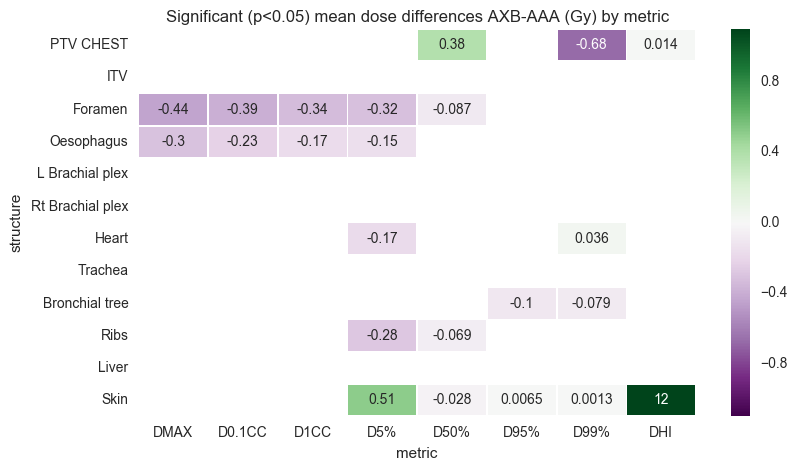

In [33]:
plt.figure(figsize=(9, 5))  
data = sub_diff_table[wilcox_data_df<0.05]

ax3 = sns.heatmap(data, annot=True, linewidths=.5, center=0, vmin = -1.1, vmax = 1.1, cmap='PRGn') #  mask=mask,
ax3.set_title('Significant (p<0.05) mean dose differences AXB-AAA (Gy) by metric', size='large');
plt.savefig('Lung_wilcox.png')

## Corr matrix

Plot the correlation matrix of dose differences between structures

0.85189643675399362

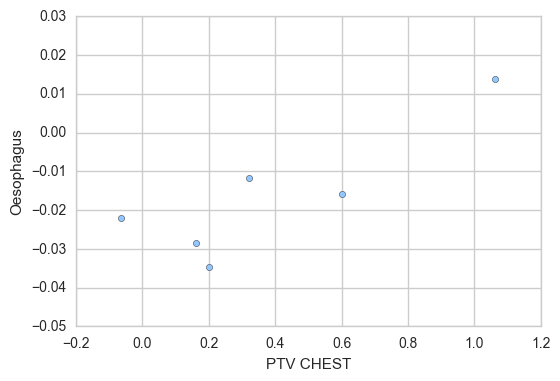

In [53]:
structure1 = 'PTV CHEST'
metric = 'D50%'
data1 = query_data(AAA_Dm_data, 'Dm-AAA', structure1, metric).values


structure2 = 'Oesophagus'
data2 = query_data(AAA_Dm_data, 'Dm-AAA', structure2, metric).values

plt.scatter(data1, data2)
plt.xlabel(structure1)
plt.ylabel(structure2)

np.corrcoef(data1, data2)[0,1]  # print the correlation coeff

In [81]:
def corr_coeff(structure1, structure2, metric):
    data1 = query_data(AAA_Dm_data, 'Dm-AAA', structure1, metric).values
    data2 = query_data(AAA_Dm_data, 'Dm-AAA', structure2, metric).values
    return np.corrcoef(data1, data2)[0,1]  # print the correlation coeff

a = corr_coeff(structure1 = 'PTV CHEST', structure2 = 'Skin', metric = 'D50%')
a

0.21721217119259778

In [90]:
structures_of_interest = ['PTV CHEST','ITV','Foramen', 'Oesophagus','Heart', 'Trachea','Bronchial tree', 'Ribs', 'Skin']  # Don't have complete data for all structures 

i = len(structures_of_interest)
j = i
corr_data = np.zeros((i,j))  # init an empty array
metric = 'DMAX'

j = 0
for structure1 in structures_of_interest:
    i = 0
    for structure2 in structures_of_interest:
        data1 = query_data(AAA_Dm_data, 'Dm-AAA', structure1, metric).values
        data2 = query_data(AAA_Dm_data, 'Dm-AAA', structure2, metric).values
        # print(str(coeff) + structure1 + ':' + str(len(data1)) + structure2 + ':' + str(len(data2)))
        coeff = np.corrcoef(data1, data2)[0,1] 
        corr_data[j][i] = coeff
       # print(structure1 + ':' + structure2)
    
        i = i + 1
    j = j+ 1
    
corr_data_df = pd.DataFrame(data=corr_data, index=structures_of_interest, columns=structures_of_interest)  # 1st row as the column names

In [91]:
# corr_data_df

mask = np.zeros_like(corr_data, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

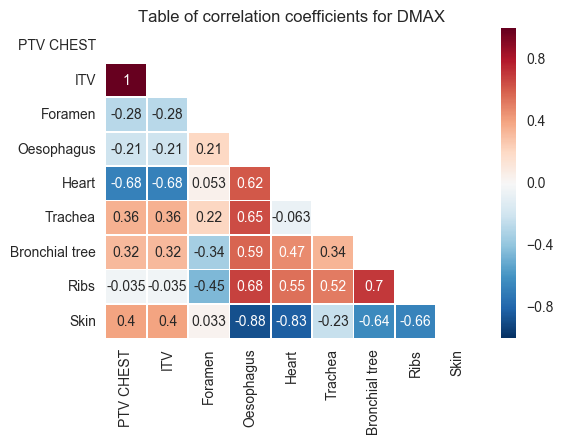

In [92]:
ax3 = sns.heatmap(corr_data_df, mask=mask, annot=True, linewidths=.5, center=0, vmin = -1.0, vmax = 1.0)
ax3.set_title('Table of correlation coefficients for ' + metric)